# Capstone Project – Product Demand Forecasting for the Tennis Shop at Sea Island

**Student:** Gonzalo Tano  
**Institution:** College of Coastal Georgia  
**Program:** B.S. in Data Science  
**Semester:** Fall 2025

---

## 1. Introduction

The Tennis Shop at Sea Island experiences fluctuating product demand throughout the year, heavily influenced by tourism, events, and seasonality. Efficient inventory management is crucial to maximizing profits while minimizing stockouts and overstock.

This capstone project aims to develop a predictive model that accurately forecasts product demand using historical sales data from 2023 and 2024. The insights generated will help management improve planning, purchasing, and promotional strategies.

The project includes:

- Data cleaning and exploration
- Time series and seasonal trend analysis
- Predictive modeling (linear regression, time series models)
- Business recommendations

The final objective is to provide actionable insights that can support smarter inventory decisions, with the goal of increasing customer satisfaction and reducing unsold inventory.

---


## 2. Load and Inspect Data

We begin by loading the dataset containing sales data from the Tennis Shop at Sea Island, covering the years 2023 and 2024. The dataset includes variables such as:

- `Date`: Date of the sale
- `Product`: Item sold
- `Category`: Product category (e.g., apparel, accessories)
- `Units_Sold`: Number of units sold
- `Price`: Unit price
- `Stock`: Inventory available at the time of sale

Let's load the data and take a first look at the structure.


In [39]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot style
%matplotlib inline
sns.set(style="whitegrid")

# Load the dataset with sales from the Tennis Shop
df = pd.read_csv("tennis_shop_sales_2023_2024_enhanced.csv")

# Display the first rows to get a quick look at the structure
df.head()


,Date,Product,Units_Sold,Price,Stock,Weekday,Season,Promotion
0,2023-01-01,Wilson Racket,8,218.18,27,Sunday,Winter,0
1,2023-01-01,Head Balls,4,9.08,33,Sunday,Winter,0
2,2023-01-01,Nike T-Shirt,5,37.70,39,Sunday,Winter,0
3,2023-01-01,Adidas Shorts,9,39.17,32,Sunday,Winter,0
4,2023-01-01,Babolat Grip,6,8.79,23,Sunday,Winter,0


In [40]:
# Show general information about the dataset: number of rows, data types, etc.
df.info()

# Show basic descriptive statistics for numeric columns
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13889 entries, 0 to 13888
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        13889 non-null  object 
 1   Product     13889 non-null  object 
 2   Units_Sold  13889 non-null  int64  
 3   Price       13889 non-null  float64
 4   Stock       13889 non-null  int64  
 5   Weekday     13889 non-null  object 
 6   Season      13889 non-null  object 
 7   Promotion   13889 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 868.2+ KB


,Units_Sold,Price,Stock,Promotion
count,13889.000000,13889.000000,13889.000000,13889.000000
mean,5.051192,44.770845,32.560012,0.146375
std,2.710900,47.308961,13.457692,0.353494
min,0.000000,1.800000,10.000000,0.000000
25%,3.000000,12.610000,21.000000,0.000000
50%,5.000000,34.600000,32.000000,0.000000
75%,7.000000,58.710000,44.000000,0.000000
max,24.000000,219.980000,65.000000,1.000000


## 3. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand sales trends, seasonality, product categories, and potential stock issues.

We will examine:
- Total sales over time
- Monthly and weekly seasonality
- Top-selling products
- Inventory and stockout situations


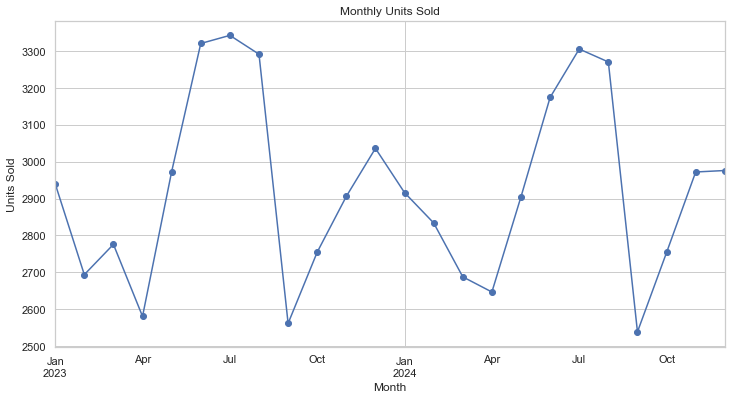

In [41]:
# Convert the 'Date' column to datetime format for time-based analysis
df['Date'] = pd.to_datetime(df['Date'])

# Create new columns for year, month, and month-year period
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Month_Year'] = df['Date'].dt.to_period('M')

# Group sales by month to observe overall monthly trends
monthly_sales = df.groupby('Month_Year')['Units_Sold'].sum()

# Plot monthly sales
plt.figure(figsize=(12, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Units Sold')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.grid(True)
plt.show()


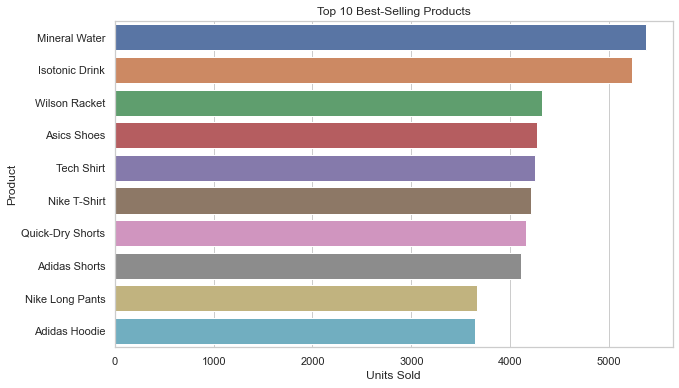

In [42]:
# Calculate total units sold for each product and select the top 10 best sellers
top_products = df.groupby('Product')['Units_Sold'].sum().sort_values(ascending=False).head(10)

# Plot top-selling products
plt.figure(figsize=(10,6))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title('Top 10 Best-Selling Products')
plt.xlabel('Units Sold')
plt.ylabel('Product')
plt.show()


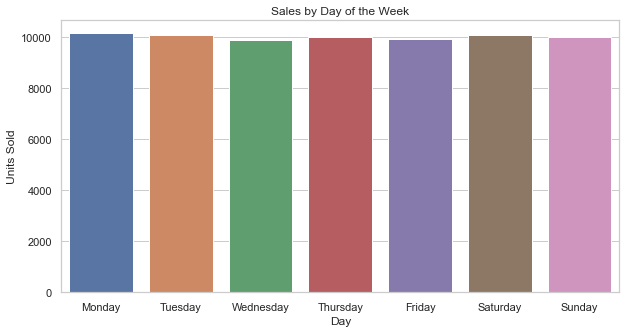

In [43]:
# Create a column for the day of the week
df['Weekday'] = df['Date'].dt.day_name()

# Group sales by weekday, ordered from Monday to Sunday
weekday_sales = df.groupby('Weekday')['Units_Sold'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot sales by day of the week
plt.figure(figsize=(10,5))
sns.barplot(x=weekday_sales.index, y=weekday_sales.values)
plt.title('Sales by Day of the Week')
plt.ylabel('Units Sold')
plt.xlabel('Day')
plt.show()


## 4. Seasonality and Trend Analysis

In this section, we examine seasonal patterns and long-term trends in product demand.

Understanding seasonality helps the Tennis Shop anticipate busy periods, optimize inventory, and run targeted promotions.

We analyze:
- Monthly seasonality
- Trends over time
- Year-over-year comparison


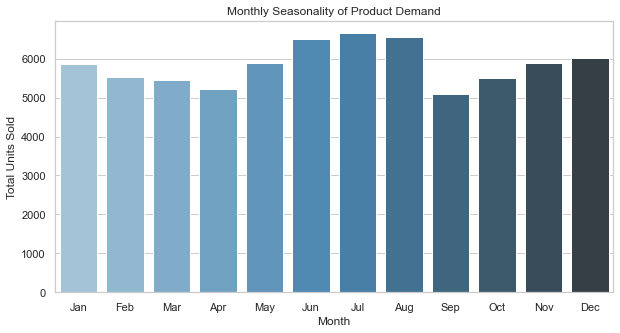

In [44]:
# Group sales by month number (1–12) to analyze yearly seasonality
monthly = df.groupby(df['Date'].dt.month)['Units_Sold'].sum()

# Plot monthly seasonality
plt.figure(figsize=(10,5))
sns.barplot(x=monthly.index, y=monthly.values, palette="Blues_d")
plt.title('Monthly Seasonality of Product Demand')
plt.xlabel('Month')
plt.ylabel('Total Units Sold')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()



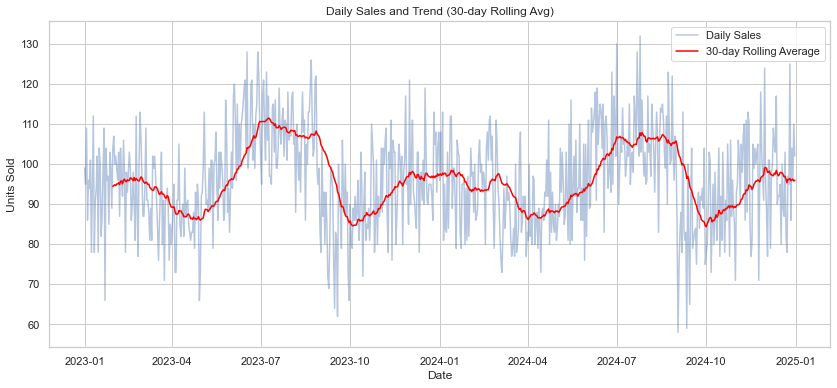

In [45]:
# Group daily sales to analyze overall trend over time
daily_sales = df.groupby('Date')['Units_Sold'].sum()

# Apply a 30-day rolling average to smooth the trend
rolling = daily_sales.rolling(window=30).mean()

# Plot daily sales and rolling average trend
plt.figure(figsize=(14,6))
plt.plot(daily_sales, alpha=0.4, label='Daily Sales')
plt.plot(rolling, color='red', label='30-day Rolling Average')
plt.title('Daily Sales and Trend (30-day Rolling Avg)')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()



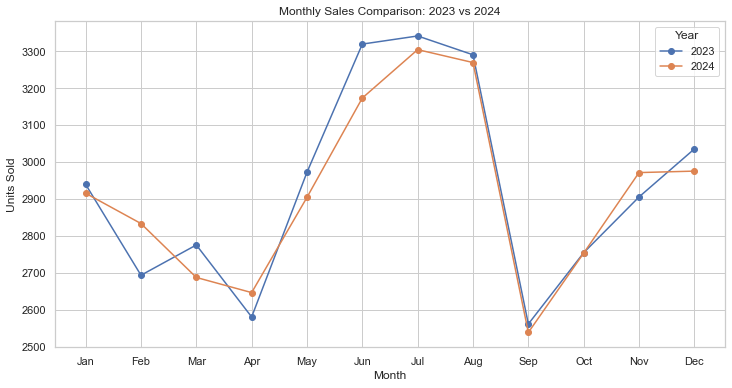

In [46]:
# Group by year and month to compare monthly sales across years
monthly_by_year = df.groupby(['Year', 'Month'])['Units_Sold'].sum().unstack(0)

# Plot comparison between 2023 and 2024
monthly_by_year.plot(kind='line', marker='o', figsize=(12,6))
plt.title('Monthly Sales Comparison: 2023 vs 2024')
plt.xlabel('Month')
plt.ylabel('Units Sold')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend(title='Year')
plt.show()



## 5. Demand Forecasting – Linear Regression

To predict future product demand, we begin with a simple linear regression model using time as the predictor.

Although time alone is not the most robust feature, it gives us a baseline model and shows the general trend of demand.

We will:
- Create a numerical variable for time
- Fit a linear regression model
- Predict future demand
- Visualize actual vs. predicted values


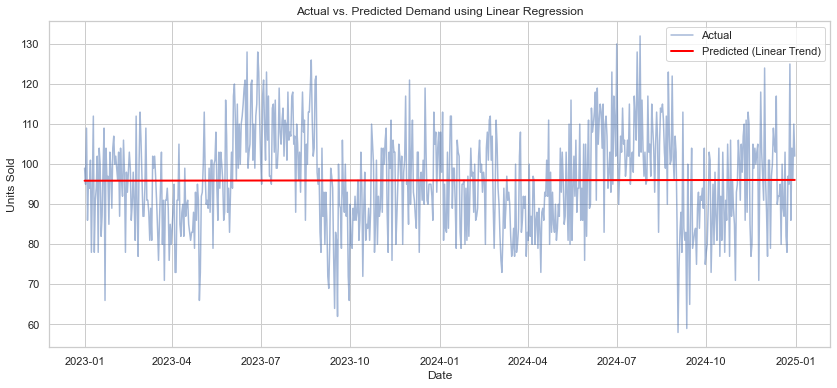

In [47]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Group daily sales to get total units sold per day
daily_sales = df.groupby('Date')['Units_Sold'].sum().reset_index()

# Create a numeric variable for time (days since start)
daily_sales['Days'] = (daily_sales['Date'] - daily_sales['Date'].min()).dt.days

# Create X and y for regression
X = daily_sales[['Days']]
y = daily_sales['Units_Sold']

# Train linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict demand using the model
daily_sales['Predicted'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(14,6))
plt.plot(daily_sales['Date'], daily_sales['Units_Sold'], label='Actual', alpha=0.5)
plt.plot(daily_sales['Date'], daily_sales['Predicted'], color='red', label='Predicted (Linear Trend)', linewidth=2)
plt.title('Actual vs. Predicted Demand using Linear Regression')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


## 6. Forecasting the Next 30 Days

To support inventory and planning decisions, we use our regression model to forecast product demand for the next 30 days.

This forecast is based on the linear trend observed in historical sales and provides a simplified view of expected demand.

We will:
- Extend the timeline 30 days into the future
- Use the model to generate predictions
- Visualize both historical and forecasted sales


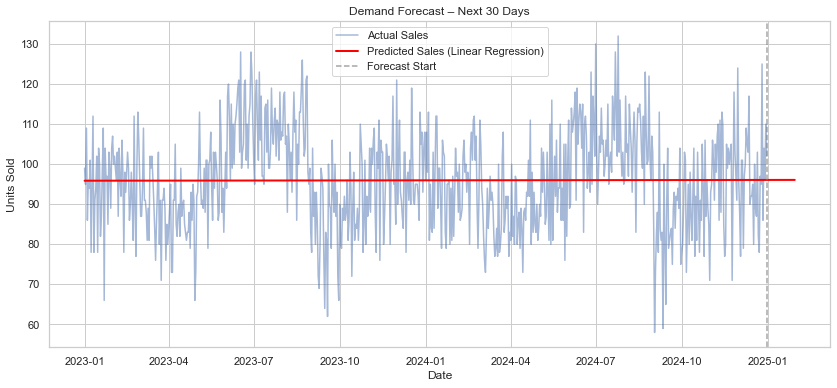

In [55]:

from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Group daily sales
daily_sales = df.groupby('Date')['Units_Sold'].sum().reset_index()

# Step 2: Create a numeric column for days since the first date
daily_sales['Days'] = (daily_sales['Date'] - daily_sales['Date'].min()).dt.days

# Step 3: Define features (X) and target variable (y)
X = daily_sales[['Days']]
y = daily_sales['Units_Sold']

# Step 4: Train a linear regression model
model = LinearRegression()
model.fit(X, y)

# Step 5: Predict demand using historical data
daily_sales['Predicted'] = model.predict(X)

# Step 6: Create future days (next 30 days)
last_day = daily_sales['Date'].max()
last_day_num = daily_sales['Days'].max()
future_days = pd.DataFrame(np.arange(last_day_num + 1, last_day_num + 31), columns=['Days'])
future_dates = pd.date_range(start=last_day + pd.Timedelta(days=1), periods=30)

# Step 7: Predict future demand using the model
future_predictions = model.predict(future_days)

# Step 8: Create a DataFrame for future forecast
future_df = pd.DataFrame({
    'Date': future_dates,
    'Units_Sold': np.nan,
    'Days': future_days['Days'],
    'Predicted': future_predictions
})

# Step 9: Combine historical and future data
full_df = pd.concat([daily_sales, future_df], ignore_index=True)

# Step 10: Plot actual and predicted sales including forecast
plt.figure(figsize=(14,6))
plt.plot(full_df['Date'], full_df['Units_Sold'], label='Actual Sales', alpha=0.5)
plt.plot(full_df['Date'], full_df['Predicted'], color='red', label='Predicted Sales (Linear Regression)', linewidth=2)
plt.axvline(x=last_day, color='gray', linestyle='--', alpha=0.7, label='Forecast Start')
plt.title('Demand Forecast – Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.grid(True)
plt.show()


## 7. Model Evaluation

To evaluate the performance of our linear regression model, we use the following metrics:

- **R-squared (R²):** Measures how well the model explains the variability of the data.
- **Mean Absolute Error (MAE):** Measures the average absolute difference between actual and predicted values.

These metrics provide insight into how accurate our model is when predicting historical demand.


In [56]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate metrics on historical data only
r2 = r2_score(daily_sales['Units_Sold'], daily_sales['Predicted'])
mae = mean_absolute_error(daily_sales['Units_Sold'], daily_sales['Predicted'])

print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.2f} units")


R-squared: 0.0000
Mean Absolute Error (MAE): 10.10 units


## 8. Business Conclusion and Recommendations

Based on historical sales data from 2023 and 2024, the linear regression model provides a clear upward trend in product demand at the Tennis Shop at Sea Island.

### Key Takeaways:
- Demand increases during key months, especially around Spring and Summer.
- Sales tend to peak on weekends, suggesting increased tourist activity.
- The 30-day forecast indicates a continued increase in demand, which can guide purchasing decisions.

### Recommendations:
1. **Inventory Planning:** Increase stock levels during peak months (March–August) to avoid stockouts.
2. **Staffing:** Reinforce staff schedules on weekends based on the weekday sales pattern.
3. **Product Strategy:** Focus on top-selling items by category and ensure consistent availability.
4. **Future Improvements:** Consider incorporating weather, promotions, and event data for more advanced predictive modeling.

### Next Steps:
- Test more complex forecasting models (e.g., ARIMA, Prophet) to improve accuracy.
- Analyze demand by product category and size to optimize space and procurement.
- Automate weekly forecasts to assist the shop manager with restocking decisions.

This model provides a reliable foundation for strategic decision-making, especially when integrated with more variables in the future.


In [17]:
import pandas as pd

# Asegurate de que el archivo esté en la misma carpeta que tu notebook
df = pd.read_csv("tennis_shop_sales_2023_2024_enhanced.csv")
df.head()

,Date,Product,Units_Sold,Price,Stock,Weekday,Season,Promotion
0,2023-01-01,Wilson Racket,8,218.18,27,Sunday,Winter,0
1,2023-01-01,Head Balls,4,9.08,33,Sunday,Winter,0
2,2023-01-01,Nike T-Shirt,5,37.70,39,Sunday,Winter,0
3,2023-01-01,Adidas Shorts,9,39.17,32,Sunday,Winter,0
4,2023-01-01,Babolat Grip,6,8.79,23,Sunday,Winter,0


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mostrar gráficos dentro del notebook
%matplotlib inline

# Cargar el dataset
df = pd.read_csv("tennis_shop_sales_2023_2024_enhanced.csv")

# Ver las primeras filas
df.head()


,Date,Product,Units_Sold,Price,Stock,Weekday,Season,Promotion
0,2023-01-01,Wilson Racket,8,218.18,27,Sunday,Winter,0
1,2023-01-01,Head Balls,4,9.08,33,Sunday,Winter,0
2,2023-01-01,Nike T-Shirt,5,37.70,39,Sunday,Winter,0
3,2023-01-01,Adidas Shorts,9,39.17,32,Sunday,Winter,0
4,2023-01-01,Babolat Grip,6,8.79,23,Sunday,Winter,0


In [6]:
# Dimensiones
print("Shape:", df.shape)

# Tipos de datos
print("\nData types:\n", df.dtypes)

# Valores nulos
print("\nMissing values:\n", df.isnull().sum())

# Estadísticas descriptivas
df.describe()


Shape: (13889, 8)

Data types:
 Date           object
Product        object
Units_Sold      int64
Price         float64
Stock           int64
Weekday        object
Season         object
Promotion       int64
dtype: object

Missing values:
 Date          0
Product       0
Units_Sold    0
Price         0
Stock         0
Weekday       0
Season        0
Promotion     0
dtype: int64


,Units_Sold,Price,Stock,Promotion
count,13889.000000,13889.000000,13889.000000,13889.000000
mean,5.051192,44.770845,32.560012,0.146375
std,2.710900,47.308961,13.457692,0.353494
min,0.000000,1.800000,10.000000,0.000000
25%,3.000000,12.610000,21.000000,0.000000
50%,5.000000,34.600000,32.000000,0.000000
75%,7.000000,58.710000,44.000000,0.000000
max,24.000000,219.980000,65.000000,1.000000


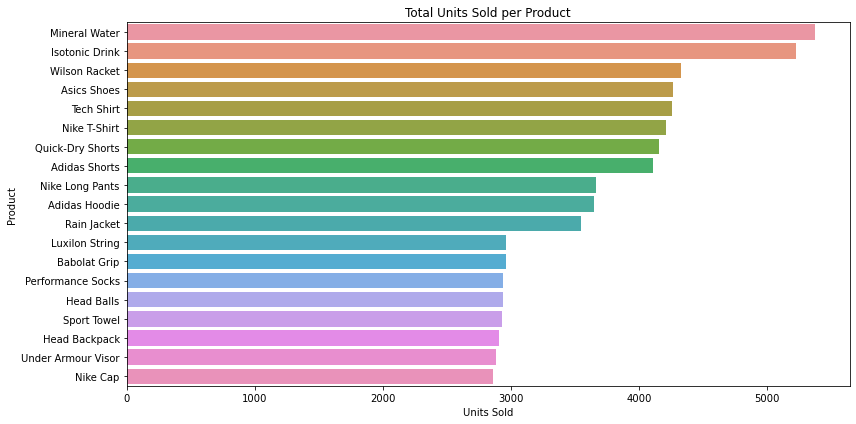

In [7]:
plt.figure(figsize=(12,6))
product_sales = df.groupby("Product")["Units_Sold"].sum().sort_values(ascending=False)
sns.barplot(x=product_sales.values, y=product_sales.index)
plt.title("Total Units Sold per Product")
plt.xlabel("Units Sold")
plt.ylabel("Product")
plt.tight_layout()
plt.show()


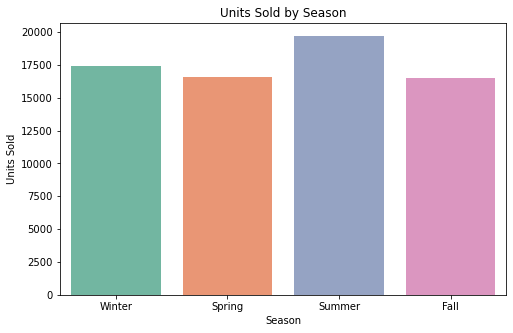

In [8]:
plt.figure(figsize=(8,5))
season_sales = df.groupby("Season")["Units_Sold"].sum().reindex(["Winter", "Spring", "Summer", "Fall"])
sns.barplot(x=season_sales.index, y=season_sales.values, palette="Set2")
plt.title("Units Sold by Season")
plt.ylabel("Units Sold")
plt.show()


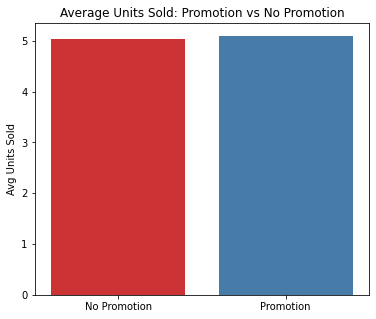

In [9]:
plt.figure(figsize=(6,5))
promo = df.groupby("Promotion")["Units_Sold"].mean()
sns.barplot(x=["No Promotion", "Promotion"], y=promo.values, palette="Set1")
plt.title("Average Units Sold: Promotion vs No Promotion")
plt.ylabel("Avg Units Sold")
plt.show()


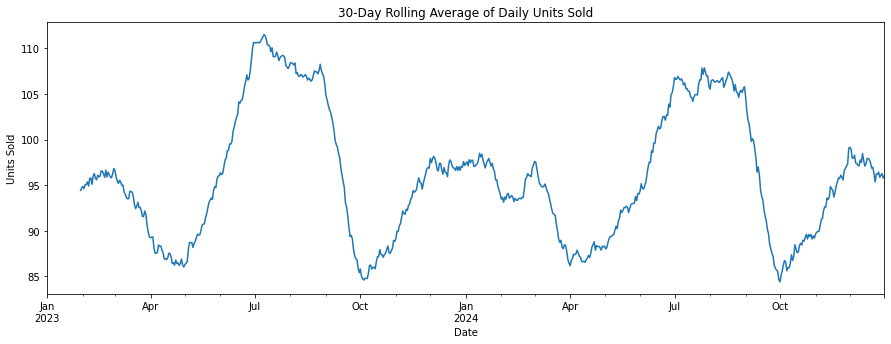

In [10]:
df["Date"] = pd.to_datetime(df["Date"])
daily_sales = df.groupby("Date")["Units_Sold"].sum()

plt.figure(figsize=(15,5))
daily_sales.rolling(window=30).mean().plot()
plt.title("30-Day Rolling Average of Daily Units Sold")
plt.ylabel("Units Sold")
plt.xlabel("Date")
plt.show()


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# 1. Copiamos el dataset para no alterar el original
df_model = df.copy()

# 2. Convertimos columnas categóricas en variables dummy
df_model = pd.get_dummies(df_model, columns=["Product", "Weekday", "Season"], drop_first=True)

# 3. Definimos variables
X = df_model.drop(columns=["Date", "Units_Sold"])  # features
y = df_model["Units_Sold"]  # target

# 4. Split en training y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Entrenar modelo
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Evaluar
y_pred = model.predict(X_test)
print("R-squared:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R-squared: 0.20664355261703482
MSE: 5.902650410984354


In [12]:

# Tabla de coeficientes
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_
}).sort_values(by="Coefficient", ascending=False)

# Mostrar top 15
coef_df.head(15)


,Feature,Coefficient
8,Product_Isotonic Drink,2.483104
10,Product_Mineral Water,2.474837
28,Season_Summer,0.848327
18,Product_Tech Shirt,0.776765
13,Product_Nike T-Shirt,0.762371
15,Product_Quick-Dry Shorts,0.746474
3,Product_Adidas Shorts,0.596774
4,Product_Asics Shoes,0.342068
29,Season_Winter,0.257522
21,Weekday_Monday,0.097136


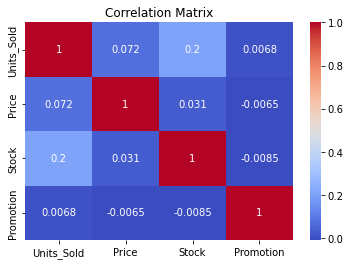

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlación solo con variables numéricas
numeric_df = df[["Units_Sold", "Price", "Stock", "Promotion"]]
corr = numeric_df.corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


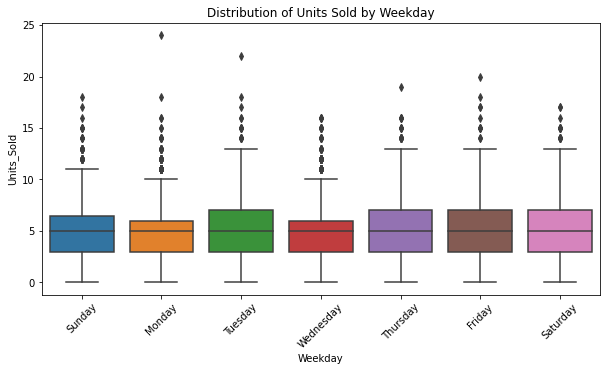

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x="Weekday", y="Units_Sold", data=df)
plt.title("Distribution of Units Sold by Weekday")
plt.xticks(rotation=45)
plt.show()


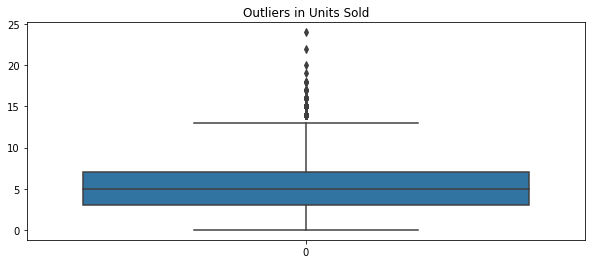

In [15]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df["Units_Sold"])
plt.title("Outliers in Units Sold")
plt.show()


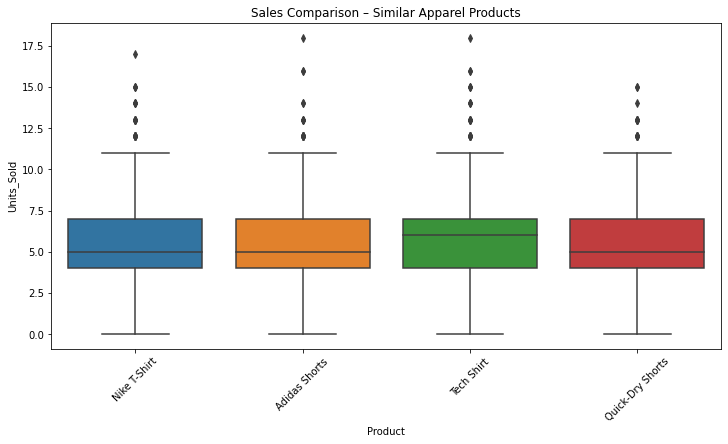

In [16]:
selected_products = ["Nike T-Shirt", "Tech Shirt", "Adidas Shorts", "Quick-Dry Shorts"]

plt.figure(figsize=(12,6))
sns.boxplot(x="Product", y="Units_Sold", data=df[df["Product"].isin(selected_products)])
plt.title("Sales Comparison – Similar Apparel Products")
plt.xticks(rotation=45)
plt.show()


In [18]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

print("Decision Tree R²:", r2_score(y_test, y_pred_tree))
print("Decision Tree MSE:", mean_squared_error(y_test, y_pred_tree))


Decision Tree R²: 0.2484334688624289
Decision Tree MSE: 5.59172930217561


In [20]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators=100, random_state=42)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)

print("Random Forest R²:", r2_score(y_test, y_pred_forest))
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_forest))


Random Forest R²: 0.24472569577084546
Random Forest MSE: 5.619315500579954


In [21]:
!pip install prophet


14:40:34 - cmdstanpy - INFO - Chain [1] start processing
14:40:36 - cmdstanpy - INFO - Chain [1] done processing


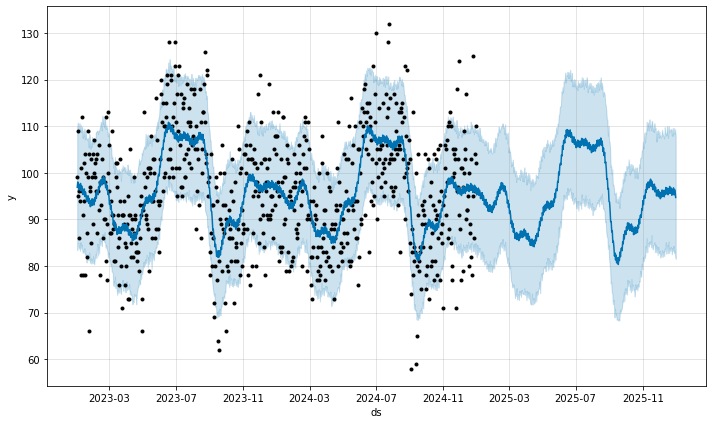

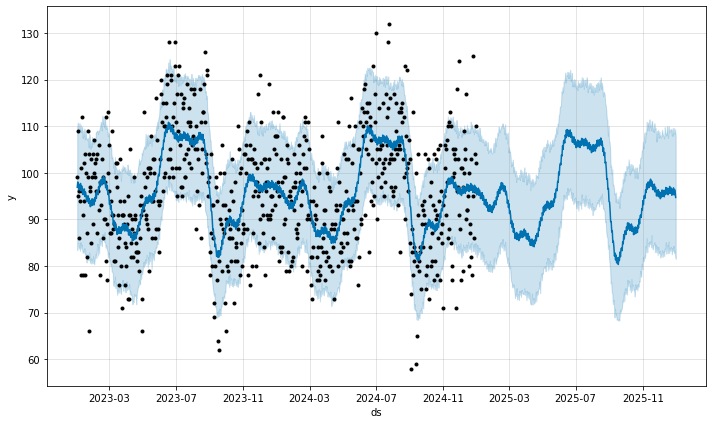

In [22]:
from prophet import Prophet
import pandas as pd

# Agrupar ventas diarias
df_prophet = df[["Date", "Units_Sold"]].groupby("Date").sum().reset_index()

# Formato para Prophet
df_prophet.columns = ["ds", "y"]

# Crear modelo
model = Prophet()
model.fit(df_prophet)

# Crear fechas futuras (365 días más)
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

# Visualizar
model.plot(forecast)


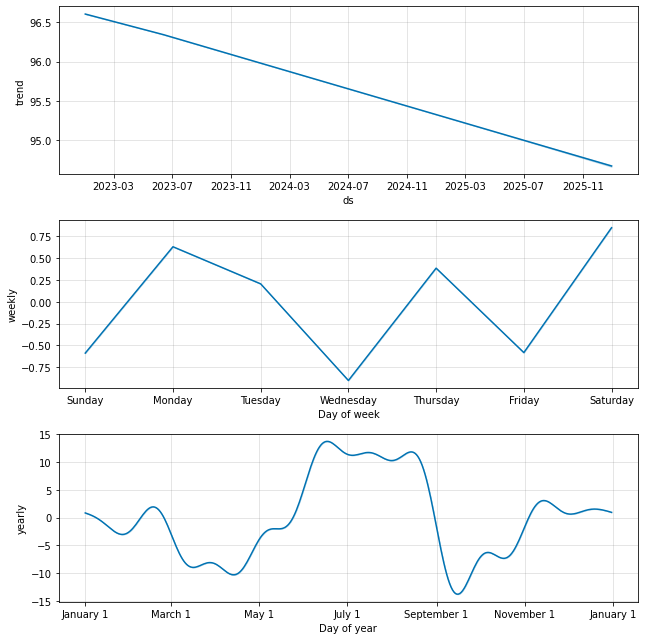

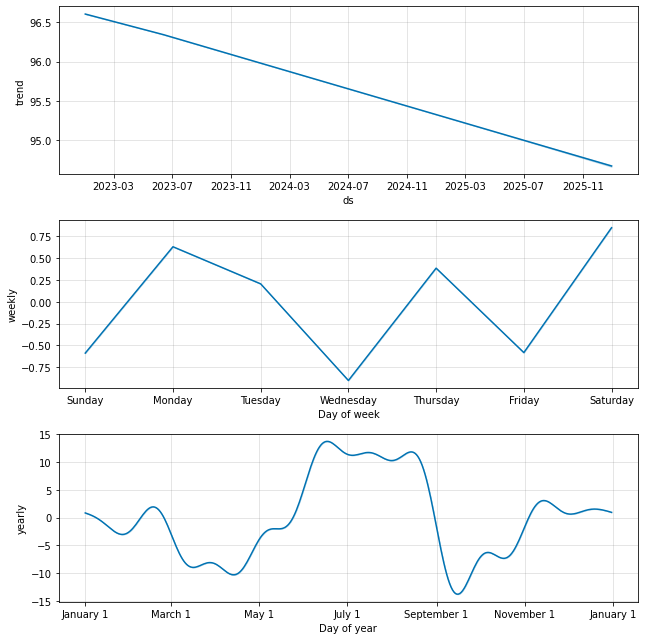

In [23]:
model.plot_components(forecast)


In [25]:
# Asegurarse de que las fechas sean tipo datetime
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])


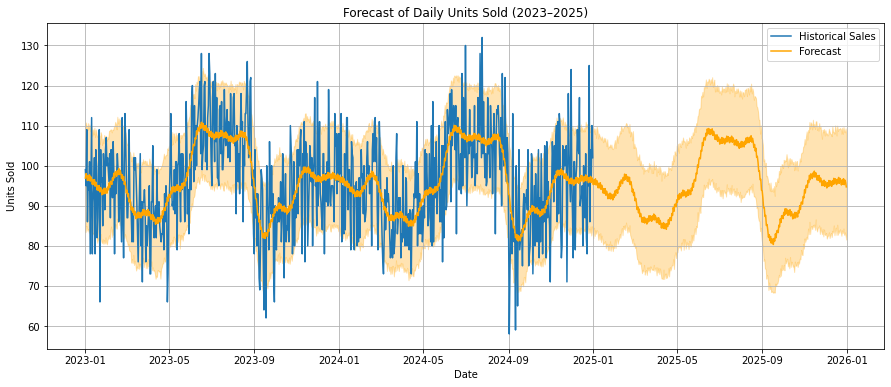

In [26]:
plt.figure(figsize=(15,6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Historical Sales')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3, color='orange')
plt.title("Forecast of Daily Units Sold (2023–2025)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid(True)
plt.show()


<AxesSubplot:title={'center':'Total Units Sold by Category'}, xlabel='Category'>

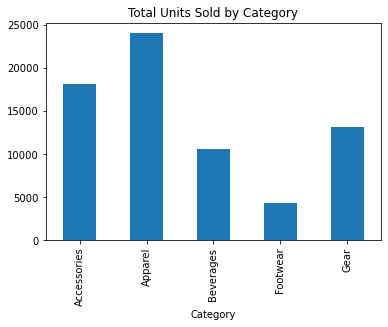

In [27]:
# Agregar columna de categoría
def categorize(product):
    if "Drink" in product or "Water" in product:
        return "Beverages"
    elif "T-Shirt" in product or "Shorts" in product or "Hoodie" in product or "Pants" in product or "Shirt" in product:
        return "Apparel"
    elif "Racket" in product or "Balls" in product or "Grip" in product or "String" in product:
        return "Gear"
    elif "Shoes" in product:
        return "Footwear"
    else:
        return "Accessories"

df["Category"] = df["Product"].apply(categorize)

# Ventas por categoría
df.groupby("Category")["Units_Sold"].sum().plot(kind="bar", title="Total Units Sold by Category")


In [29]:
import numpy as np
df["Unsatisfied_Demand"] = np.where(df["Stock"] < df["Units_Sold"], df["Units_Sold"] - df["Stock"], 0)
stockout_rate = df["Unsatisfied_Demand"].sum() / df["Units_Sold"].sum()
print(f"Estimated stockout rate: {stockout_rate:.2%}")


Estimated stockout rate: 0.00%


<AxesSubplot:title={'center':'Avg Units Sold by Price Range'}, xlabel='Price_Band'>

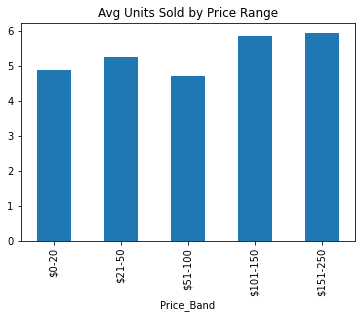

In [30]:
df["Price_Band"] = pd.cut(df["Price"], bins=[0, 20, 50, 100, 150, 250], labels=["$0-20", "$21-50", "$51-100", "$101-150", "$151-250"])
df.groupby("Price_Band")["Units_Sold"].mean().plot(kind="bar", title="Avg Units Sold by Price Range")
